<a href="https://colab.research.google.com/github/Mombinjenga/Potato-Disease-Detector/blob/main/Potato_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Import core libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow / Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten, Dropout
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import utilities
from sklearn.metrics import classification_report, confusion_matrix


In [12]:
# Define dataset base path
DATASET_PATH = "/content/potato-dataset/PlantVillage"

# List folders inside the dataset
print("Dataset folders:", os.listdir(DATASET_PATH))

# Check images count per class
for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        print(folder, "->", len(os.listdir(folder_path)), "images")


Dataset folders: ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']
Potato___Early_blight -> 1000 images
Potato___healthy -> 152 images
Potato___Late_blight -> 1000 images


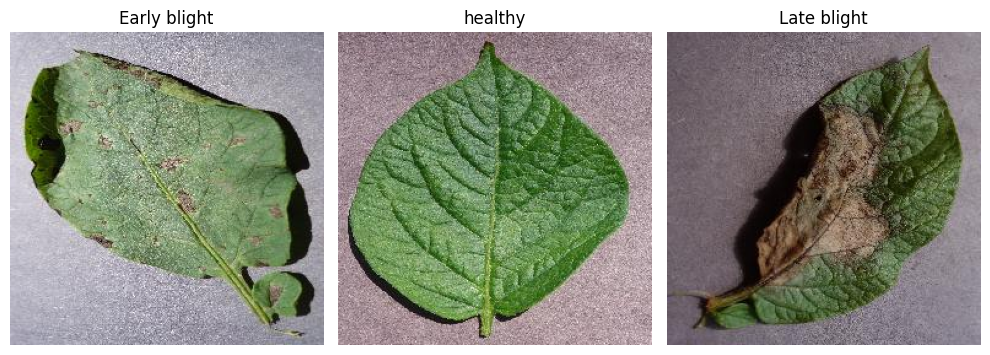

In [13]:
# Visualize sample images from each class

import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10, 6))

for i, folder in enumerate(os.listdir(DATASET_PATH)):
    folder_path = os.path.join(DATASET_PATH, folder)
    image_name = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, image_name)

    img = plt.imread(image_path)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(folder.replace("Potato___", "").replace("_", " "))
    plt.axis("off")

plt.tight_layout()
plt.show()


In [15]:
# Preprocessing images and splitting dataset
# Import required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data augmentation for training set (helps model generalize)
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values
    rotation_range=20,     # Random rotation
    width_shift_range=0.1, # Horizontal shift
    height_shift_range=0.1,# Vertical shift
    shear_range=0.1,       # Shear
    zoom_range=0.1,        # Zoom
    horizontal_flip=True,  # Flip horizontally
    validation_split=0.2   # 20% for validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1722 images belonging to 3 classes.
Found 430 images belonging to 3 classes.


In [16]:
# CNN MODEL FOR POTATO DISEASE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Input image dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Number of classes
NUM_CLASSES = 3

# Build the CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Second convolutional block
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Third convolutional block
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Flatten the output
    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,923 (12.61 MB)

 Trainable params: 3,305,475 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)